# Import Data + Setup Model

In [1]:
import pandas as pd
import numpy as np
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from helper_fncts.soe_model import *

# I load calibration_data from R
ro.r['load']('../clean_data/calibration_data.RData')

# Convert R data frames to pandas DataFrames
with localconverter(ro.default_converter + pandas2ri.converter):
    Omega = ro.r['Omega_mat']
    Delta = ro.r['Delta_mat']
    calibration_data = ro.r['calibration_vectors']
    industry_tfp = ro.r['industry_TFP']

# Compute labor shares based on calibration data
N = calibration_data.shape[0]
omega_mat = Omega

# set omega values <1e-2 to zero
# and renormalize rows to sum to 1
omega_mat[omega_mat < 1e-2] = 0
omega_mat = omega_mat / omega_mat.sum(axis=1, keepdims=True)

alpha_vec = calibration_data['alpha_it'].to_numpy()
beta_vec = calibration_data['beta_it'].to_numpy()
# check omega and beta sum to 1
print("Sum of beta (should be 1):")
print(sum(beta_vec))
print("Rowsums of Omega (should be 1):")
print(omega_mat.sum(axis=1))
# Check labor
xi_mat = np.eye(N) - (omega_mat.T * (1 - alpha_vec))
xi_inv = np.linalg.solve(xi_mat, np.eye(N))
L_vec = alpha_vec * (xi_inv @ beta_vec)
print("Labor check (should sum to 1):")
print(L_vec.sum())
# add as column to calibration_data
calibration_data['L_it'] = L_vec

Sum of beta (should be 1):
0.9999999999999998
Rowsums of Omega (should be 1):
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Labor check (should sum to 1):
1.0


# Solve for Equilibrium Response to Severe Shocks

## Solve Severe Domestic Productivity Shocks

In [3]:
# Initialize results dataframe
shock_size = 0.25 # 25% productivity shock
severe_shocks_results = pd.DataFrame(
    index=range(N),
    columns=['main', 'main_closed', 'common_theta', 'common_theta_closed']
)

# Define configurations for outer loop
configs = {
    'main': {
        'delta': Delta,
        'theta': calibration_data['theta_i'].to_numpy()
    },
    'main_closed': {
        'delta': np.ones_like(Delta),  # All 1s for closed economy
        'theta': calibration_data['theta_i'].to_numpy()
    },
    'common_theta': {
        'delta': Delta,
        'theta': calibration_data['theta_uniform'].to_numpy()
    },
    'common_theta_closed': {
        'delta': np.ones_like(Delta),
        'theta': calibration_data['theta_uniform'].to_numpy()
    }
}

# Outer loop: iterate over configurations (columns)
for config_name, config in configs.items():
    print(f"\n{'='*60}")
    print(f"Configuration: {config_name}")
    print(f"{'='*60}")

    # Create model parameters
    params = create_example_parameters(N=66)
    # Baseline values
    params.omega = omega_mat
    params.alpha = alpha_vec
    params.beta = beta_vec
    params.L = L_vec
    params.epsilon = 0.6
    params.sigma = calibration_data['sigma'].mean()
    params.gamma = calibration_data['gamma_uniform'].to_numpy()
    # Set parameters for this configuration
    params.delta = config['delta'].copy()
    params.theta = config['theta'].copy()
    model = SOEModel(params, verbose=True)

    # Inner loop: shock each sector one-by-one (rows)
    for sector_idx in range(N):
        # Apply 50% productivity cut to this sector
        params.Z[sector_idx] = 1 - shock_size

        # Solve equilibrium
        solved = model.solve(verbose=False, method = 'minimize')

        # Store consumption response
        severe_shocks_results.loc[sector_idx, config_name] = solved['C']

        print(f"  Sector {sector_idx + 1}/{N} shocked. C = {solved['C']:.6f}")

        # Reset productivity for this sector
        params.Z[sector_idx] = 1.0

print(f"\n{'='*60}")
print("All configurations completed!")
print(f"{'='*60}")

# Display results
print("\nResults DataFrame:")
print(severe_shocks_results.head(10))

# Save results
severe_shocks_results.insert(0, 'Industry', calibration_data['Industry'].values) # Add industry names
severe_shocks_results['main_minus_common'] = ((severe_shocks_results['main'] - severe_shocks_results['common_theta']))
severe_shocks_results['main_closed_minus_common_closed'] = ((severe_shocks_results['main_closed'] - severe_shocks_results['common_theta_closed']))
severe_shocks_results.sort_values(by='main_minus_common', inplace=True, ascending=False)
severe_shocks_results.to_csv('../clean_data/severe_shocks_results.csv', index=True)

print("\nResults saved!")


Configuration: main
Initializing model and calibrating NX_i at non-stochastic equilibrium...
Target: P_d[i] = 1, W_i = 1 for all i
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.1879e-30                                    1.04e-13    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 2.1879e-30, final cost 2.1879e-30, first-order optimality 1.04e-13.
Solver success: True
Max absolute residual: 8.88e-16
Min/Max P_d: 1.0000 / 1.0000
Min/Max Y_d: 0.0000 / 0.2383
Min/Max W: 1.0000 / 1.0000
P_C: 1.000000
E: 1.000000

Wage income at baseline: 1.000000

Calibrated NX: [-1.11022302e-16  1.73472348e-17  2.49611938e-02  3.46944695e-18
 -4.33680869e-18  0.00000000e+00  0.00000000e+00  1.52655666e-16
  3.82787171e-03  7.96523851e-04  0.00000000e+00 -6.93889390e-18
  1.08420217e-19 -1.38777878e-17  2.77555756e-17  0.00000000e+00
 -1.73472348e-18 -2.77555756e-17 -3.46944695e-17  1.11085827e-0

## Solve Severe Foreign Price Shocks
Only for tradeable sectors.

In [6]:
# Identify tradeable sectors (where delta_j != 1 for any i)
# delta[i,j] represents domestic share in Armington for input j used by sector i
# A sector j is tradeable if any delta[i,j] != 1

# Check which sectors have delta != 1 (tradeable)
tradeable_mask = np.any(Delta != 1, axis=0)
tradeable_sectors = np.where(tradeable_mask)[0]
print(f"Number of tradeable sectors: {len(tradeable_sectors)}")
print(f"Tradeable sector indices: {tradeable_sectors}")
print(f"Tradeable sector names:")
for idx in tradeable_sectors:
    print(f"  {idx}: {calibration_data['Industry'].iloc[idx]}")

# Initialize results dataframes
shock_size = 0.25  # 25% increase in foreign prices

# Results for consumption response
foreign_price_shock_results = pd.DataFrame(
    index=tradeable_sectors,
    columns=['main', 'main_closed', 'common_theta', 'common_theta_closed']
)

# Results for sectoral price responses (N columns for each tradeable sector shocked)
sectoral_price_responses = {
    'main': pd.DataFrame(index=tradeable_sectors, columns=[f'sector_{i}' for i in range(N)]),
    'common_theta': pd.DataFrame(index=tradeable_sectors, columns=[f'sector_{i}' for i in range(N)])
}

# Define configurations
configs = {
    'main': {
        'delta': Delta,
        'theta': calibration_data['theta_i'].to_numpy()
    },
    'main_closed': {
        'delta': np.ones_like(Delta),  # All 1s for closed economy
        'theta': calibration_data['theta_i'].to_numpy()
    },
    'common_theta': {
        'delta': Delta,
        'theta': calibration_data['theta_uniform'].to_numpy()
    },
    'common_theta_closed': {
        'delta': np.ones_like(Delta),
        'theta': calibration_data['theta_uniform'].to_numpy()
    }
}

# Outer loop: iterate over configurations
for config_name, config in configs.items():
    print(f"\n{'='*60}")
    print(f"Configuration: {config_name}")
    print(f"{'='*60}")
    
    # Create model parameters
    params = create_example_parameters(N=66)
    # Baseline values
    params.omega = omega_mat
    params.alpha = alpha_vec
    params.beta = beta_vec
    params.L = L_vec
    params.epsilon = 0.6
    params.sigma = calibration_data['sigma'].mean()
    params.gamma = calibration_data['gamma_uniform'].to_numpy()
    # Set parameters for this configuration
    params.delta = config['delta'].copy()
    params.theta = config['theta'].copy()
    model = SOEModel(params, verbose=True)
    
    # Inner loop: shock each tradeable sector's foreign price one-by-one
    for sector_idx in tradeable_sectors:
        # Apply 50% increase in foreign price for this sector
        params.P_f[sector_idx] = 1 + shock_size
        
        # Solve equilibrium
        solved = model.solve(verbose=False, method='minimize')
        
        # Store consumption response
        foreign_price_shock_results.loc[sector_idx, config_name] = solved['C']
        
        # Store sectoral price responses for main and common_theta configs
        if config_name in ['main', 'common_theta']:
            sectoral_price_responses[config_name].loc[sector_idx, :] = solved['P_d']
        
        print(f"  Sector {sector_idx + 1}/{N} ({calibration_data['Industry'].iloc[sector_idx][:30]}) shocked. C = {solved['C']:.6f}")
        
        # Reset foreign price for this sector
        params.P_f[sector_idx] = 1.0

print(f"\n{'='*60}")
print("All configurations completed!")
print(f"{'='*60}")

# Add industry names
foreign_price_shock_results.insert(0, 'Industry', calibration_data['Industry'].iloc[tradeable_sectors].values)

# Compute differences
foreign_price_shock_results['main_minus_common'] = (
    foreign_price_shock_results['main'].astype(float) - 
    foreign_price_shock_results['common_theta'].astype(float)
)
foreign_price_shock_results['main_closed_minus_common_closed'] = (
    foreign_price_shock_results['main_closed'].astype(float) - 
    foreign_price_shock_results['common_theta_closed'].astype(float)
)

# Sort and display
foreign_price_shock_results_sorted = foreign_price_shock_results.sort_values(
    by='main_minus_common', ascending=False
)

print("\nForeign Price Shock Results (sorted by main_minus_common):")
print(foreign_price_shock_results_sorted.head(10))

# Save consumption results
foreign_price_shock_results.to_csv('../clean_data/foreign_price_shock_consumption.csv', index=True)

# Save sectoral price responses
for config_name in ['main', 'common_theta']:
    sectoral_price_responses[config_name].to_csv(
        f'../clean_data/foreign_price_shock_sectoral_prices_{config_name}.csv',
        index=True
    )

print("\nResults saved to:")
print("  ../clean_data/foreign_price_shock_consumption.csv")
print("  ../clean_data/foreign_price_shock_sectoral_prices_main.csv")
print("  ../clean_data/foreign_price_shock_sectoral_prices_common_theta.csv")

Number of tradeable sectors: 10
Tradeable sector indices: [ 0  2  8  9 19 20 21 22 24 25]
Tradeable sector names:
  0: Farms
  2: Oil and gas extraction
  8: Textile mills and textile product mills
  9: Apparel and leather and allied products
  19: Machinery
  20: Computer and electronic products
  21: Electrical equipment, appliances, and components
  22: Motor vehicles, bodies and trailers, and parts
  24: Furniture and related products
  25: Miscellaneous manufacturing

Configuration: main
Initializing model and calibrating NX_i at non-stochastic equilibrium...
Target: P_d[i] = 1, W_i = 1 for all i
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.1879e-30                                    1.04e-13    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 2.1879e-30, final cost 2.1879e-30, first-order optimality 1.04e-13.
Solver success: True
Max absolute residual: 8.88e-16
Min/Max 

## Severe Domestic Productivity Shocks Table

In [1]:
import pandas as pd
# Load severe shocks results
severe_shocks = pd.read_csv('../clean_data/severe_shocks_results.csv', index_col=0)

# Function to truncate industry names at 30 characters
def truncate_industry(name):
    if len(name) > 50:
        return name[:50] + '...'
    return name

# Create tables with the specified columns
def create_table(df):
    table = pd.DataFrame()
    table['Industry'] = df['Industry'].apply(truncate_industry)
    table['Main'] = ((df['main'] - 1) * 100).apply(lambda x: f'{x:.2f}\\%')
    table['Uniform'] = ((df['common_theta'] - 1) * 100).apply(lambda x: f'{x:.2f}\\%')
    table['Change'] = (df['main'] - df['common_theta'])*100  #  ((1 - ((df['main'] - 1) / (df['common_theta'] - 1)))*100)
    return table

# Create the full table first to get \% Change values
full_table = create_table(severe_shocks)

# Sort by \% Change and select top 5 and bottom 5
full_table_sorted = full_table.sort_values(by='Change', ascending=False)
# now format \% Change column
full_table_sorted['Change'] = full_table_sorted['Change'].apply(lambda x: f'{x:.2f}\\%')
top_3_table = full_table_sorted.head(3)
bottom_3_table = full_table_sorted.tail(3)
# put top 3 and then bottom 3 as one table
combined_table = pd.concat([top_3_table, bottom_3_table], ignore_index=True)
combined_table_tex = combined_table.to_latex(index=False, escape=False)
# add separator row between top and bottom 3
lines = combined_table_tex.splitlines()
lines.insert(4, r'\midrule')
lines.insert(5, r'\multicolumn{2}{l}{\textbf{Smaller GDP loss}} \\')
lines.insert(6, r'\midrule')
# add a blank line
lines.insert(10, r'\midrule')
lines.insert(11, r'\multicolumn{2}{l}{\textbf{Larger GDP loss}} \\')
lines.insert(12, r'\midrule')
latex_table = '\n'.join(lines)
with open("../tables/severe_shocks_top3_bottom3.tex", "w") as f:
    f.write(latex_table)

## Severe Foreign Price Shocks Table

In [4]:
import pandas as pd
import numpy as np

# Load sectoral price responses
prices_main = pd.read_csv('../clean_data/foreign_price_shock_sectoral_prices_main.csv', index_col=0)
prices_common = pd.read_csv('../clean_data/foreign_price_shock_sectoral_prices_common_theta.csv', index_col=0)
foreign_consumption = pd.read_csv('../clean_data/foreign_price_shock_consumption.csv', index_col=0)

# Get shocked sector industry names from the foreign consumption file
shocked_industry_names = foreign_consumption['Industry'].to_dict()

# Get all sector industry names from calibration_data (loaded earlier in the notebook)
all_industry_names = calibration_data['Industry'].tolist()

# Function to truncate industry names
def truncate_industry(name, max_len=30):
    if len(name) > max_len:
        return name[:max_len] + '...'
    return name

tradeable_sectors = prices_main.index.tolist()

# Extract sector 2 and sector 20 tables as latex table
combined_tables = []
for shocked_sector_idx in [2, 20]:
    # Get price responses for this shock
    main_prices = prices_main.loc[shocked_sector_idx].values
    common_prices = prices_common.loc[shocked_sector_idx].values

    # Create dataframe with proper sector names
    diff_df = pd.DataFrame({
        'Sector': [truncate_industry(name, max_len=75) for name in all_industry_names],
        'Main': (main_prices - 1) * 100,
        'Uniform': (common_prices - 1) * 100,
        'Difference': (main_prices - common_prices) * 100
    })

    # Sort by Main price increase (descending) and get top 3
    top_3 = diff_df.sort_values('Main', ascending=False).head(3).copy()

    # Format columns
    top_3['Main'] = top_3['Main'].apply(lambda x: f'{x:.3f}\\%')
    top_3['Uniform'] = top_3['Uniform'].apply(lambda x: f'{x:.3f}\\%')
    top_3['Difference'] = top_3['Difference'].apply(lambda x: f'{x:.3f}\\%')

    combined_tables.append(top_3)

# Combine and save with row labels
combined_df = pd.concat(combined_tables, ignore_index=True)
combined_tex = combined_df.to_latex(index=False, escape=False)

# Add separator rows with sector names from all_industry_names
sector_2_name = all_industry_names[2]
sector_20_name = all_industry_names[20]

lines = combined_tex.splitlines()
# Insert label for sector 2 shock after header
lines.insert(4, r'\midrule')
lines.insert(5, r'\multicolumn{4}{l}{\textbf{Shock to ' + sector_2_name + r' import prices}} \\')
lines.insert(6, r'\midrule')
# Insert label for sector 20 shock after sector 2's 3 rows
lines.insert(10, r'\midrule')
lines.insert(11, r'\multicolumn{4}{l}{\textbf{Shock to ' + sector_20_name + r' import prices}} \\')
lines.insert(12, r'\midrule')

combined_latex = '\n'.join(lines)
with open("../tables/foreign_price_shock_sectors_2_20_combined.tex", "w") as f:
    f.write(combined_latex)

print(f"\nCombined table saved to ../tables/foreign_price_shock_sectors_2_20_combined.tex")
print(f"  Sector 2: {sector_2_name}")
print(f"  Sector 20: {sector_20_name}")


Combined table saved to ../tables/foreign_price_shock_sectors_2_20_combined.tex
  Sector 2: Oil and gas extraction
  Sector 20: Computer and electronic products


# Solve for Equilibrium Response to Calibrated Shocks

## Part 1: Draw TFP Shocks

In [3]:
from scipy.stats import multivariate_normal
# generate the covariance matrix of the industry TFP
industry_tfp_annual = industry_tfp.pivot(index='Code', columns='year', values='delta_tfp_1').to_numpy()
industry_tfp_vcov_annual = np.cov(industry_tfp_annual)
industry_tfp_quadrennial = industry_tfp.pivot(index='Code', columns='year', values='delta_tfp_4').to_numpy()
industry_tfp_vcov_quadrennial = np.cov(industry_tfp_quadrennial)
# set off diagonal elements to zero (assume uncorrelated shocks)
industry_tfp_mean_annual = -np.diag(industry_tfp_vcov_annual)/2 # mean 0 in logs isn't mean 0 in levels
industry_tfp_mean_quadrennial = -np.diag(industry_tfp_vcov_quadrennial)/2 # mean 0 in logs isn't mean 0 in levels
industry_tfp_vcov_annual = np.diag(np.diag(industry_tfp_vcov_annual))
industry_tfp_vcov_quadrennial = np.diag(np.diag(industry_tfp_vcov_quadrennial))
def draw_multivariate_normal(mean_vector, cov_matrix, num_samples, seed=None):
    rng = np.random.default_rng(seed)
    # mean_vector = np.zeros(cov_matrix.shape[0]) # Mean vector (zero mean)
    samples = multivariate_normal.rvs(mean=mean_vector, cov=(cov_matrix), size=num_samples, random_state=rng) # Generate samples from the multivariate normal distribution using the RNG
    return samples
tfp_samples = draw_multivariate_normal(industry_tfp_mean_quadrennial, industry_tfp_vcov_quadrennial, 1000, seed=42)

## Part 2: Compute Equilibrium Responses

In [ ]:
# Initialize results dataframe for aggregate consumption
calibration_shocks_results = pd.DataFrame(
    index=range(1000),
    columns=['cobbdouglas', 'cobbdouglas_closed', 'main', 'main_closed', 'common_theta', 'common_theta_closed']
)

# Initialize dictionaries to store sectoral output dataframes for each configuration
sectoral_output_results = {
    'cobbdouglas': pd.DataFrame(index=range(1000), columns=[f'sector_{i}' for i in range(N)]),
    'cobbdouglas_closed': pd.DataFrame(index=range(1000), columns=[f'sector_{i}' for i in range(N)]),
    'main': pd.DataFrame(index=range(1000), columns=[f'sector_{i}' for i in range(N)]),
    'main_closed': pd.DataFrame(index=range(1000), columns=[f'sector_{i}' for i in range(N)]),
    'common_theta': pd.DataFrame(index=range(1000), columns=[f'sector_{i}' for i in range(N)]),
    'common_theta_closed': pd.DataFrame(index=range(1000), columns=[f'sector_{i}' for i in range(N)])
}

# Initialize dictionaries to store sectoral price dataframes for each configuration
sectoral_price_results = {
    'cobbdouglas': pd.DataFrame(index=range(1000), columns=[f'sector_{i}' for i in range(N)]),
    'cobbdouglas_closed': pd.DataFrame(index=range(1000), columns=[f'sector_{i}' for i in range(N)]),
    'main': pd.DataFrame(index=range(1000), columns=[f'sector_{i}' for i in range(N)]),
    'main_closed': pd.DataFrame(index=range(1000), columns=[f'sector_{i}' for i in range(N)]),
    'common_theta': pd.DataFrame(index=range(1000), columns=[f'sector_{i}' for i in range(N)]),
    'common_theta_closed': pd.DataFrame(index=range(1000), columns=[f'sector_{i}' for i in range(N)])
}

# Define configurations (same as severe shocks)
configs = {
    'cobbdouglas': {
        'delta': Delta,
        'theta': np.ones_like(calibration_data['theta_i'].to_numpy())
    },
    'cobbdouglas_closed': {
        'delta': np.ones_like(Delta),
        'theta': np.ones_like(calibration_data['theta_i'].to_numpy())
    },
    'main': {
        'delta': Delta,
        'theta': calibration_data['theta_i'].to_numpy()
    },
    'main_closed': {
        'delta': np.ones_like(Delta),  # All 1s for closed economy
        'theta': calibration_data['theta_i'].to_numpy()
    },
    'common_theta': {
        'delta': Delta,
        'theta': calibration_data['theta_uniform'].to_numpy()
    },
    'common_theta_closed': {
        'delta': np.ones_like(Delta),
        'theta': calibration_data['theta_uniform'].to_numpy()
    }
}

# Outer loop: iterate over configurations (columns)
for config_name, config in configs.items():
    print(f"\n{'='*60}")
    print(f"Configuration: {config_name}")
    print(f"{'='*60}")

    # Create model parameters
    params = create_example_parameters(N=66)
    # Baseline values
    params.omega = omega_mat
    params.alpha = alpha_vec
    params.beta = beta_vec
    params.L = L_vec
    params.epsilon = 0.6
    params.sigma = calibration_data['sigma'].mean()
    params.gamma = calibration_data['gamma_uniform'].to_numpy()
    # Set parameters for this configuration
    params.delta = config['delta'].copy()
    params.theta = config['theta'].copy()
    model = SOEModel(params, verbose=True)

    # Inner loop: iterate over 1000 TFP draws (rows)
    for draw_idx in range(1000):
        # Apply TFP shock from draw (tfp_samples are in logs, so exponentiate)
        params.Z = np.exp(tfp_samples[draw_idx, :])

        # Solve equilibrium
        solved = model.solve(verbose=False, method='minimize')

        # Store aggregate consumption response
        calibration_shocks_results.loc[draw_idx, config_name] = solved['C']

        # Store all 66 sectoral outputs
        sectoral_output_results[config_name].loc[draw_idx, :] = solved['Y_d']
        
        # Store all 66 sectoral prices
        sectoral_price_results[config_name].loc[draw_idx, :] = solved['P_d']
        
        print(f"  Draw {draw_idx + 1}/1000 completed. C = {solved['C']:.6f}")

        # Reset productivity to baseline
        params.Z = np.ones(N)

print(f"\n{'='*60}")
print("All configurations completed!")
print(f"{'='*60}")

# Display results
print("\nAggregate Consumption Results DataFrame:")
print(calibration_shocks_results.head(10))

# Save results
calibration_shocks_results.to_csv('../clean_data/calibration_shocks_results.csv', index=True)

# Save sectoral output results for each configuration
for config_name in configs.keys():
    sectoral_output_results[config_name].to_csv(
        f'../clean_data/sectoral_outputs_{config_name}.csv',
        index=True
    )

# Save sectoral price results for each configuration
for config_name in configs.keys():
    sectoral_price_results[config_name].to_csv(
        f'../clean_data/sectoral_prices_{config_name}.csv',
        index=True
    )

print("\nResults saved!")

## Look at Aggregate Responses

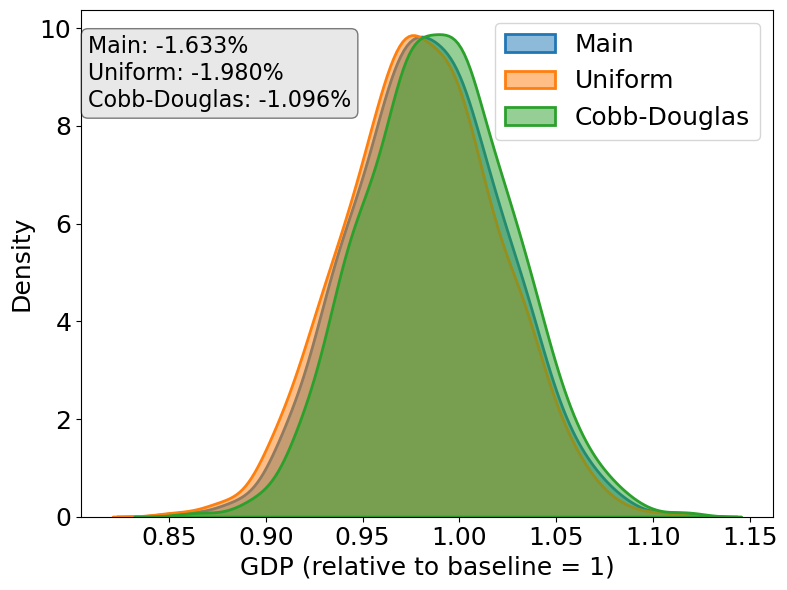

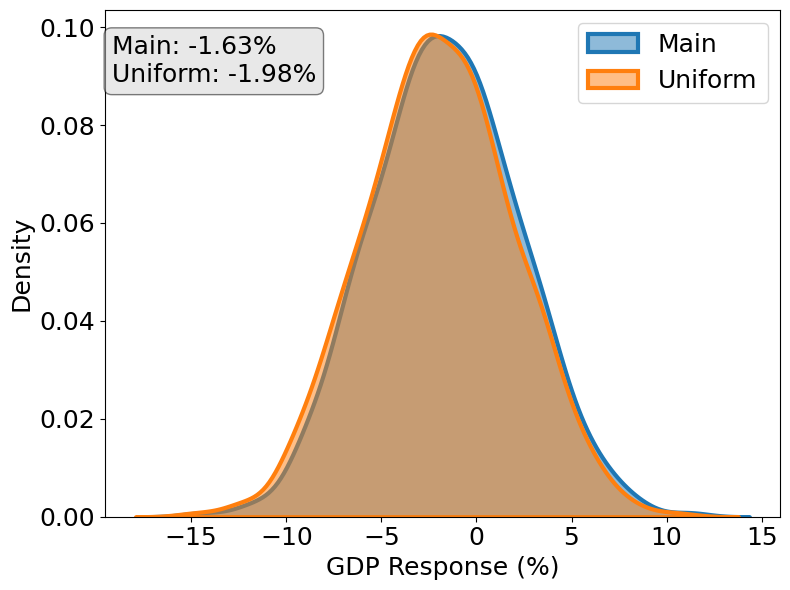

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load the calibration shocks results from CSV
calibration_shocks_results = pd.read_csv('../clean_data/calibration_shocks_results.csv', index_col=0)

# Define consistent colors for Main and Uniform (Common Theta)
color_main = '#1f77b4'  # Blue
color_uniform = '#ff7f0e'  # Orange
color_cobbdouglas = '#2ca02c'  # Green

# Calculate means
mean_main = calibration_shocks_results['main'].mean()
mean_common = calibration_shocks_results['common_theta'].mean()
mean_cobbdouglas = calibration_shocks_results['cobbdouglas'].mean()

# Going to report as %losses, 
loss_main = (mean_main-1) * 100
loss_common = (mean_common-1) * 100
loss_cobbdouglas = (mean_cobbdouglas-1) * 100

# Plot 1: With Cobb-Douglas (relative to baseline of 1)
plt.figure(figsize=(8,6))
sns.kdeplot(calibration_shocks_results['main'], label='Main', fill=True, alpha=0.5, linewidth=2, color=color_main)
sns.kdeplot(calibration_shocks_results['common_theta'], label='Uniform', fill=True, alpha=0.5, linewidth=2, color=color_uniform)
sns.kdeplot(calibration_shocks_results['cobbdouglas'], label='Cobb-Douglas', fill=True, alpha=0.5, linewidth=2, color=color_cobbdouglas)
plt.xlabel('GDP (relative to baseline = 1)', fontsize = 18)
plt.ylabel('Density', fontsize = 18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize = 18)
# Add means in textbox
plt.text(0.01, 0.95, f'Main: {loss_main:.3f}%\nUniform: {loss_common:.3f}%\nCobb-Douglas: {loss_cobbdouglas:.3f}%',
         horizontalalignment='left', verticalalignment='top', transform=plt.gca().transAxes,
         bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='lightgray', alpha=0.5), fontsize=16)
plt.tight_layout()
plt.savefig('../figures/aggregate_responses_with_cd.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Plot 2: Without Cobb-Douglas
# - 1 to plot % changes
plt.figure(figsize=(8,6))
sns.kdeplot((calibration_shocks_results['main'] - 1)*100, label='Main', fill=True, alpha=0.5, linewidth=3, color=color_main)
sns.kdeplot((calibration_shocks_results['common_theta'] - 1)*100, label='Uniform', fill=True, alpha=0.5, linewidth=3, color=color_uniform)
plt.xlabel('GDP Response (%)', fontsize = 18)
plt.ylabel('Density', fontsize = 18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize = 18)
# Add means in textbox
plt.text(0.01, 0.95, f'Main: {loss_main:.2f}%\nUniform: {loss_common:.2f}%',
         horizontalalignment='left', verticalalignment='top', transform=plt.gca().transAxes,
         bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='lightgray', alpha=0.5), fontsize=18)
plt.tight_layout()
plt.savefig('../figures/aggregate_responses.pdf', dpi=300, bbox_inches='tight')
plt.show()

# output a simple tex table listing the means, std dev., and skew for Main and Uniform
def compute_stats(series):
    mean = series.mean()
    std_dev = series.std()
    skewness = series.skew()
    return mean, std_dev, skewness

config_name_dict = {
    'main': 'Main',
    'common_theta': 'Uniform'
}
rows = []
for config_name in ['main', 'common_theta']:
    mean, std_dev, skewness = compute_stats((calibration_shocks_results[config_name] - 1)*100) # convert to % change
    rows.append({
        'Calibration': config_name_dict[config_name],
        'Mean': f'{mean:.2f}\%',
        'Std Dev': f'{std_dev:.2f}\%',
        'Skewness': f'{skewness:.2f}\%'
    })
stats_table = pd.DataFrame(rows)

# Save stats table as LaTeX
stats_table.to_latex('../tables/aggregate_response_stats.tex', index=False, escape=False)

## Normalize Sectoral Results

Normalize sectoral results by baseline levels to get percentage deviations.

In [4]:
# load sectoral output results from saved files (if needed)
import pandas as pd

# Define configurations (same as severe shocks)
configs = {
    'cobbdouglas': {
        'delta': Delta,
        'theta': np.ones_like(calibration_data['theta_i'].to_numpy())
    },
    'cobbdouglas_closed': {
        'delta': np.ones_like(Delta),
        'theta': np.ones_like(calibration_data['theta_i'].to_numpy())
    },
    'main': {
        'delta': Delta,
        'theta': calibration_data['theta_i'].to_numpy()
    },
    'main_closed': {
        'delta': np.ones_like(Delta),  # All 1s for closed economy
        'theta': calibration_data['theta_i'].to_numpy()
    },
    'common_theta': {
        'delta': Delta,
        'theta': calibration_data['theta_uniform'].to_numpy()
    },
    'common_theta_closed': {
        'delta': np.ones_like(Delta),
        'theta': calibration_data['theta_uniform'].to_numpy()
    }
}

sectoral_output_results = {}
sectoral_price_results = {}
for config_name in configs.keys():
    sectoral_output_results[config_name] = pd.read_csv(
        f'../clean_data/sectoral_outputs_{config_name}.csv',
        index_col=0
    )
    sectoral_price_results[config_name] = pd.read_csv(
        f'../clean_data/sectoral_prices_{config_name}.csv',
        index_col=0
    )
    
# Normalize sectoral_output_results by baseline (no-shock) case
baseline_outputs = {}
baseline_prices = {}

# Compute baseline outputs and prices for each configuration
for config_name, config in configs.items():
    print(f"Computing baseline for {config_name}...")
    
    # Create model parameters
    params = create_example_parameters(N=66)
    params.omega = omega_mat
    params.alpha = alpha_vec
    params.beta = beta_vec
    params.L = L_vec
    params.epsilon = 0.6
    params.sigma = calibration_data['sigma'].mean()
    params.gamma = calibration_data['gamma_j'].to_numpy()
    params.delta = config['delta'].copy()
    params.theta = config['theta'].copy()
    
    # Set Z to ones (no shock)
    params.Z = np.ones(N)
    
    model = SOEModel(params, verbose=False)
    baseline_solved = model.solve(verbose=False, method='minimize')
    baseline_outputs[config_name] = baseline_solved['Y_d']
    baseline_prices[config_name] = baseline_solved['P_d']
    print(f"  Baseline C = {baseline_solved['C']:.6f}")

# Normalize all sectoral outputs and prices by their respective baselines
for config_name in sectoral_output_results.keys():
    print(f"Normalizing {config_name}...")
    sectoral_output_results[config_name] = sectoral_output_results[config_name] / baseline_outputs[config_name]
    sectoral_price_results[config_name] = sectoral_price_results[config_name] / baseline_prices[config_name]

print("\nNormalization complete! All sectoral outputs and prices are now relative to baseline (Z=1).")

Computing baseline for cobbdouglas...
  Baseline C = 1.000000
Computing baseline for cobbdouglas_closed...
  Baseline C = 1.000000
Computing baseline for main...
  Baseline C = 1.000000
Computing baseline for main_closed...
  Baseline C = 1.000000
Computing baseline for common_theta...
  Baseline C = 1.000000
Computing baseline for common_theta_closed...
  Baseline C = 1.000000
Normalizing cobbdouglas...
Normalizing cobbdouglas_closed...
Normalizing main...
Normalizing main_closed...
Normalizing common_theta...
Normalizing common_theta_closed...

Normalization complete! All sectoral outputs and prices are now relative to baseline (Z=1).


## Look at Sectoral Responses (Prices)

In [19]:
# compare main and common-theta configurations for PRICES
# dataframe with main, common-theta: mean, std, 5th percentile, 95th percentile
# for each sector
price_comparison_stats = pd.DataFrame(
    index=range(N),
    columns=['mean_main', 'std_main', '5th_percentile_main', '95th_percentile_main',
             'mean_common_theta', 'std_common_theta', '5th_percentile_common_theta', '95th_percentile_common_theta']
)
for sector_idx in range(N):
    # Main configuration stats
    main_sector_data = sectoral_price_results['main'][f'sector_{sector_idx}']
    price_comparison_stats.loc[sector_idx, 'mean_main'] = main_sector_data.mean()
    price_comparison_stats.loc[sector_idx, 'std_main'] = main_sector_data.std()
    price_comparison_stats.loc[sector_idx, '5th_percentile_main'] = main_sector_data.quantile(0.05)
    price_comparison_stats.loc[sector_idx, '95th_percentile_main'] = main_sector_data.quantile(0.95)
    
    # Common-theta configuration stats
    common_theta_sector_data = sectoral_price_results['common_theta'][f'sector_{sector_idx}']
    price_comparison_stats.loc[sector_idx, 'mean_common_theta'] = common_theta_sector_data.mean()
    price_comparison_stats.loc[sector_idx, 'std_common_theta'] = common_theta_sector_data.std()
    price_comparison_stats.loc[sector_idx, '5th_percentile_common_theta'] = common_theta_sector_data.quantile(0.05)
    price_comparison_stats.loc[sector_idx, '95th_percentile_common_theta'] = common_theta_sector_data.quantile(0.95)

# Add industry names
price_comparison_stats.insert(0, 'Industry', calibration_data['Industry'].values)

price_comparison_stats['main_minus_common'] = price_comparison_stats['mean_main'] - price_comparison_stats['mean_common_theta']
price_comparison_stats

,Industry,mean_main,std_main,5th_percentile_main,95th_percentile_main,mean_common_theta,std_common_theta,5th_percentile_common_theta,95th_percentile_common_theta,main_minus_common
0,Farms,1.03178,0.2173,0.744992,1.419397,1.024473,0.208146,0.743884,1.394711,0.007307
1,"Forestry, fishing, and related activities",1.022487,0.313388,0.603258,1.635219,1.010522,0.307621,0.597352,1.59893,0.011965
2,Oil and gas extraction,1.064305,0.279963,0.685677,1.575948,1.050885,0.277296,0.671463,1.563254,0.01342
3,"Mining, except oil and gas",1.033637,0.214791,0.724089,1.436862,1.026054,0.218372,0.712186,1.443134,0.007583
4,Support activities for mining,1.116187,0.515138,0.504347,2.081996,1.063064,0.361946,0.58536,1.733236,0.053123
...,...,...,...,...,...,...,...,...,...,...
61,Accommodation,0.997473,0.082412,0.874411,1.134861,0.99342,0.084048,0.862775,1.137156,0.004053
62,Food services and drinking places,0.998099,0.048897,0.919308,1.079852,0.994972,0.050032,0.915675,1.077381,0.003127
63,"Other services, except government",0.994281,0.054018,0.90531,1.081573,0.988989,0.072288,0.870391,1.104593,0.005292
64,Housing,0.995112,0.078815,0.870662,1.125221,1.007524,0.090181,0.869321,1.167965,-0.012412


### Save as Table

In [26]:
# Create table for top 3 industries by price mean increase (Main vs Uniform)
import pandas as pd

# Function to truncate industry names at 20 characters
def truncate_industry(name):
    if len(name) > 75:
        return name[:75] + '...'
    return name

# Sort by main_minus_common (difference in mean prices) and get top 3
top_3_data = price_comparison_stats.sort_values(by='main_minus_common', ascending=False).head(3)

# Create table with means and difference
top_3_price_table = pd.DataFrame()
top_3_price_table['Industry'] = top_3_data['Industry'].apply(truncate_industry).values
top_3_price_table['Main'] = ((top_3_data['mean_main'] - 1) * 100).apply(lambda x: f'{x:.2f}\\%').values
top_3_price_table['Uniform'] = ((top_3_data['mean_common_theta'] - 1) * 100).apply(lambda x: f'{x:.2f}\\%').values
top_3_price_table['Difference'] = (top_3_data['main_minus_common'] * 100).apply(lambda x: f'{x:.2f}\\%').values

# Save table as LaTeX
top_3_price_table.to_latex('../tables/price_top3.tex', index=False, escape=False)

print("="*80)
print("Top 3 Industries by Price Mean Increase (Main vs Uniform)")
print("="*80)
print(top_3_price_table.to_string(index=False))

print("\nTable saved to:")
print("  ../tables/price_top3.tex")

Top 3 Industries by Price Mean Increase (Main vs Uniform)
                     Industry    Main Uniform Difference
Support activities for mining 11.62\%  6.31\%     5.31\%
       Oil and gas extraction  6.43\%  5.09\%     1.34\%
  Petroleum and coal products  4.57\%  3.37\%     1.20\%

Table saved to:
  ../tables/price_top3.tex


## Look at Sectoral Responses (Output)

In [5]:
# compare main and common-theta configurations
# dataframe with main, common-theta: mean, std, 5th percentile, 95th percentile
# for each sector
comparison_stats = pd.DataFrame(
    index=range(N),
    columns=['mean_main', 'std_main', '5th_percentile_main', '95th_percentile_main',
             'mean_common_theta', 'std_common_theta', '5th_percentile_common_theta', '95th_percentile_common_theta']
)
for sector_idx in range(N):
    # Main configuration stats
    main_sector_data = sectoral_output_results['main'][f'sector_{sector_idx}']
    comparison_stats.loc[sector_idx, 'mean_main'] = main_sector_data.mean()
    comparison_stats.loc[sector_idx, 'std_main'] = main_sector_data.std()
    comparison_stats.loc[sector_idx, '5th_percentile_main'] = main_sector_data.quantile(0.05)
    comparison_stats.loc[sector_idx, '95th_percentile_main'] = main_sector_data.quantile(0.95)
    
    # Common-theta configuration stats
    common_theta_sector_data = sectoral_output_results['common_theta'][f'sector_{sector_idx}']
    comparison_stats.loc[sector_idx, 'mean_common_theta'] = common_theta_sector_data.mean()
    comparison_stats.loc[sector_idx, 'std_common_theta'] = common_theta_sector_data.std()
    comparison_stats.loc[sector_idx, '5th_percentile_common_theta'] = common_theta_sector_data.quantile(0.05)
    comparison_stats.loc[sector_idx, '95th_percentile_common_theta'] = common_theta_sector_data.quantile(0.95)

    # Add industry names
comparison_stats.insert(0, 'Industry', calibration_data['Industry'].values)

comparison_stats['main_minus_common'] = comparison_stats['mean_main'] - comparison_stats['mean_common_theta']
# comparison_stats.sort_values(by='main_minus_common', inplace=True, ascending=False)
comparison_stats

,Industry,mean_main,std_main,5th_percentile_main,95th_percentile_main,mean_common_theta,std_common_theta,5th_percentile_common_theta,95th_percentile_common_theta,main_minus_common
0,Farms,0.981169,0.056571,0.883274,1.073256,0.982215,0.063536,0.87543,1.086544,-0.001046
1,"Forestry, fishing, and related activities",0.994276,0.077834,0.874685,1.127876,0.994086,0.077263,0.877441,1.126842,0.000189
2,Oil and gas extraction,0.980197,0.188196,0.701648,1.326,0.982835,0.1915,0.700245,1.325852,-0.002637
3,"Mining, except oil and gas",0.986042,0.06007,0.893114,1.087228,0.983789,0.061313,0.887442,1.085711,0.002252
4,Support activities for mining,0.973079,0.063846,0.867224,1.073299,0.98102,0.11471,0.806465,1.171701,-0.007942
...,...,...,...,...,...,...,...,...,...,...
61,Accommodation,0.987357,0.042818,0.922939,1.061741,0.985749,0.042353,0.920342,1.059347,0.001608
62,Food services and drinking places,0.985239,0.033152,0.931612,1.040366,0.98342,0.033472,0.930291,1.038723,0.00182
63,"Other services, except government",0.989519,0.040819,0.921829,1.055758,0.986589,0.036316,0.927837,1.045325,0.00293
64,Housing,0.98959,0.06609,0.886675,1.099539,0.979939,0.069845,0.870554,1.095494,0.00965


### Save as Table

In [6]:
# Create tables for calibrated shocks (top 3 and bottom 3)
import pandas as pd

# Function to truncate industry names at 20 characters
def truncate_industry(name):
    if len(name) > 20:
        return name[:20] + '...'
    return name

# Create table with Main and Uniform mean outputs
def create_calibrated_table(df):
    table = pd.DataFrame()
    table['Industry'] = df['Industry'].apply(truncate_industry)
    table['Main'] = ((df['mean_main'] - 1) * 100).apply(lambda x: f'{x:.2f}\\%')
    table['Uniform'] = ((df['mean_common_theta'] - 1) * 100).apply(lambda x: f'{x:.2f}\\%')
    table['Change'] = (df['main_minus_common'] * 100)
    return table

# Create the full table
full_calibrated_table = create_calibrated_table(comparison_stats)

# Sort by Change and select top 3 and bottom 3
full_calibrated_sorted = full_calibrated_table.sort_values(by='Change', ascending=False)
# Format Change column
full_calibrated_sorted['Change'] = full_calibrated_sorted['Change'].apply(lambda x: f'{x:.2f}\\%')
top_3_calibrated = full_calibrated_sorted.head(3)
bottom_3_calibrated = full_calibrated_sorted.tail(3)

# Save tables as LaTeX
top_3_calibrated.to_latex('../tables/calibrated_shocks_top3.tex', index=False, escape=False)
bottom_3_calibrated.to_latex('../tables/calibrated_shocks_bottom3.tex', index=False, escape=False)

print("Top 3 Industries (highest Change - Main minus Uniform):")
print(top_3_calibrated.to_string(index=False))
print("\n" + "="*80 + "\n")
print("Bottom 3 Industries (lowest Change - Main minus Uniform):")
print(bottom_3_calibrated.to_string(index=False))

# Create combined table (top 3 + bottom 3)
combined_calibrated = pd.concat([top_3_calibrated, bottom_3_calibrated], ignore_index=True)
combined_calibrated_tex = combined_calibrated.to_latex(index=False, escape=False)

# Add separator rows between top and bottom 3
lines = combined_calibrated_tex.splitlines()
lines.insert(4, r'\midrule')
lines.insert(5, r'\multicolumn{2}{l}{\textbf{Larger average output}} \\')
lines.insert(6, r'\midrule')
lines.insert(10, r'\midrule')
lines.insert(11, r'\multicolumn{2}{l}{\textbf{Smaller average output}} \\')
lines.insert(12, r'\midrule')
latex_table = '\n'.join(lines)

with open("../tables/calibrated_shocks_top3_bottom3.tex", "w") as f:
    f.write(latex_table)

Top 3 Industries (highest Change - Main minus Uniform):
               Industry    Main Uniform Change
Insurance carriers a...  0.36\% -1.06\% 1.42\%
                Housing -1.04\% -2.01\% 0.97\%
Motion picture and s... -0.79\% -1.57\% 0.78\%


Bottom 3 Industries (lowest Change - Main minus Uniform):
               Industry    Main Uniform  Change
Petroleum and coal p... -1.85\% -1.68\% -0.17\%
Oil and gas extracti... -1.98\% -1.72\% -0.26\%
Support activities f... -2.69\% -1.90\% -0.79\%
